# 2024-04-20 - silx_RadonTransformTesting.ipynb
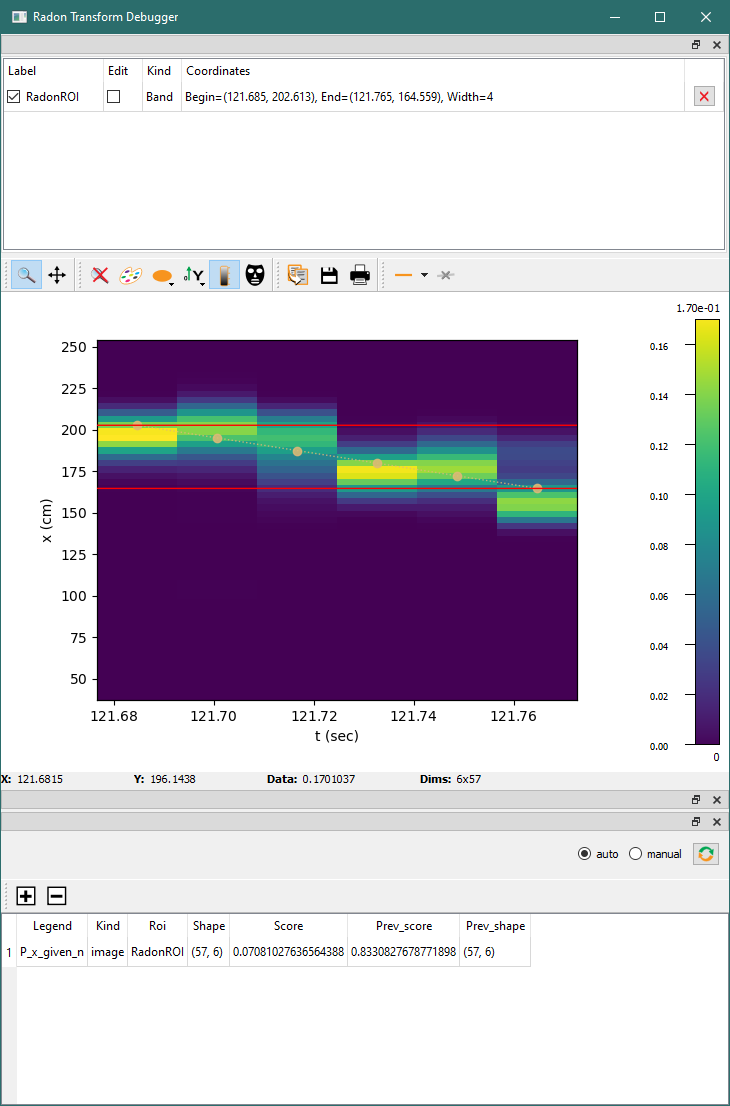

In [1]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
# %load_ext viztracer
# from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
# from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy
from attrs import define, field, fields, Factory
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
import builtins

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython

from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# BEGIN PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #


## IPython pprint
from pyphocorehelpers.pprint import wide_pprint, wide_pprint_ipython, wide_pprint_jupyter, MAX_LINE_LENGTH

# Override default pprint
builtins.pprint = wide_pprint

text_formatter: PlainTextFormatter = IPython.get_ipython().display_formatter.formatters['text/plain']
text_formatter.max_width = MAX_LINE_LENGTH
text_formatter.for_type(object, wide_pprint_jupyter)


# END PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

from pyphocorehelpers.print_helpers import get_now_time_str, get_now_day_str

## Pho's Custom Libraries:
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path, file_uri_from_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types

from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.utils.matplotlib_helpers import matplotlib_file_only, matplotlib_configuration, matplotlib_configuration_update
from neuropy.core.neuron_identities import NeuronIdentityTable, neuronTypesList, neuronTypesEnum
from neuropy.utils.mixins.AttrsClassHelpers import AttrsBasedClassHelperMixin, serialized_field, serialized_attribute_field, non_serialized_field, custom_define
from neuropy.utils.mixins.HDF5_representable import HDF_DeserializationMixin, post_deserialize, HDF_SerializationMixin, HDFMixin, HDF_Converter

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.neurons import NeuronType
from neuropy.core.user_annotations import UserAnnotationsManager
from neuropy.core.position import Position
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot
from neuropy.analyses.decoders import RadonTransformComputation, RadonTransformDebugValue, radon_transform
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns
from neuropy.utils.debug_helpers import parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from neuropy.utils.indexing_helpers import NumpyHelpers, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies, paired_incremental_sorting
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage, print_value_overview_only, DocumentationFilePrinter, print_keys_if_possible, generate_html_string, document_active_variables

## Pho Programming Helpers:
import inspect
from pyphocorehelpers.print_helpers import DocumentationFilePrinter, TypePrintMode, print_keys_if_possible, debug_dump_object_member_shapes, print_value_overview_only, document_active_variables
from pyphocorehelpers.programming_helpers import IPythonHelpers, PythonDictionaryDefinitionFormat, MemoryManagement, inspect_callable_arguments, get_arguments_as_optional_dict, GeneratedClassDefinitionType, CodeConversion
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper, print_widget_hierarchy
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative, dict_to_full_array
# doc_output_parent_folder: Path = Path('EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation').resolve() # ../.
# print(f"doc_output_parent_folder: {doc_output_parent_folder}")
# assert doc_output_parent_folder.exists()

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

import pyphoplacecellanalysis.External.pyqtgraph as pg

from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
from pyphoplacecellanalysis.General.Batch.runBatch import BatchSessionCompletionHandler # for `post_compute_validate(...)`
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends # for `_perform_long_short_instantaneous_spike_rate_groups_analysis`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation, TruncationCheckingResults # for `BatchSessionCompletionHandler`, `AcrossSessionsAggregator`
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalComputationFunctions, DirectionalLapsResult, TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer, RankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses


# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')
# %matplotlib inline
# %matplotlib auto

# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

# import pylustrator # call `pylustrator.start()` before creating your first figure in code.
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import _build_default_tick, build_scatter_plot_kwargs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import Render2DScrollWindowPlotMixin, ScatterItemData
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_programmatic_figures, batch_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_3, main_complete_figure_generations
from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import *

# Jupyter Widget Interactive
import ipywidgets as widgets
from IPython.display import display, HTML
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, render_colors

from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str

DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

NOW_DATETIME: str = get_now_rounded_time_str()
NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')


from pyphocorehelpers.gui.Jupyter.simple_widgets import build_global_data_root_parent_path_selection_widget
all_paths = [Path('/Volumes/SwapSSD/Data'), Path('/Users/pho/data'), Path(r'/media/MAX/Data'), Path(r'/media/halechr/MAX/Data'), Path(r'/home/halechr/FastData'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data')]
global_data_root_parent_path = None
def on_user_update_path_selection(new_path: Path):
    global global_data_root_parent_path
    new_global_data_root_parent_path = new_path.resolve()
    global_data_root_parent_path = new_global_data_root_parent_path
    print(f'global_data_root_parent_path changed to {global_data_root_parent_path}')
    assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
            
global_data_root_parent_path_widget = build_global_data_root_parent_path_selection_widget(all_paths, on_user_update_path_selection)
global_data_root_parent_path_widget



Automatic pdb calling has been turned OFF
DAY_DATE_STR: 2025-01-22, DAY_DATE_TO_USE: 2025-01-22
NOW_DATETIME: 2025-01-22_0113PM, NOW_DATETIME_TO_USE: 2025-01-22_0113PM
global_data_root_parent_path changed to W:\Data


ToggleButtons(description='Data Root:', layout=Layout(width='auto'), options=(WindowsPath('W:/Data'),), style=ToggleButtonsStyle(button_width='max-content'), tooltip='global_data_root_parent_path', value=WindowsPath('W:/Data'))

In [2]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtGui, QtCore, QtWidgets
# from pyphoplacecellanalysis.External.pyqtgraph.parametertree.parameterTypes.file import popupFilePicker
from pyphoplacecellanalysis.External.pyqtgraph.widgets.FileDialog import FileDialog

from silx.gui import qt
from silx.gui.dialog.ImageFileDialog import ImageFileDialog
from silx.gui.dialog.DataFileDialog import DataFileDialog
import silx.io

from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import saveFile
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData

from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult


# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-02-13_CustomDecodingResults.pkl").resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-02-13_9pm_CustomDecodingResults.pkl").resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-02-14_CustomDecodingResults.pkl").resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\output\2024-02-15_CustomDecodingResults.pkl").resolve()
# load_path = Path("/media/halechr/MAX/Data/KDIBA/gor01/one/2006-6-08_14-26-15/output/2024-02-15_CustomDecodingResults.pkl").resolve()
# load_path = Path("/Users/pho/data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-02-16_CustomDecodingResults.pkl").resolve()
# load_path = Path("/Users/pho/data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-02-14_CustomDecodingResults.pkl").resolve()
# load_path = Path("/Users/pho/data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-04-25_CustomDecodingResults.pkl").resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-04-25_CustomDecodingResults.pkl").resolve() # APOGEE
load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-04-28_CustomDecodingResults.pkl").resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\two\2006-6-09_22-24-40\output\2024-04-28_CustomDecodingResults.pkl").resolve() # APOGEE


assert load_path.exists()
# loaded_dict = loadData(load_path, debug_print=False)
# print_keys_if_possible('loaded_dict', loaded_dict)

base_loaded_dict = loadData(load_path, debug_print=False)
xbin = base_loaded_dict.pop('xbin', None)
xbin_centers = base_loaded_dict.pop('xbin_centers', None)
# ybin = deepcopy(long_pf2D.ybin)
# ybin_centers = deepcopy(long_pf2D.ybin_centers)
print(f"xbin_centers: {xbin_centers}")

loaded_dict = base_loaded_dict['directional_decoders_epochs_decode_result']


## UNPACK HERE:
pos_bin_size: float = loaded_dict['pos_bin_size'] # 3.8632841399651463
ripple_decoding_time_bin_size = loaded_dict['ripple_decoding_time_bin_size']
laps_decoding_time_bin_size = loaded_dict['laps_decoding_time_bin_size']
decoder_laps_filter_epochs_decoder_result_dict = loaded_dict['decoder_laps_filter_epochs_decoder_result_dict']
decoder_ripple_filter_epochs_decoder_result_dict = loaded_dict['decoder_ripple_filter_epochs_decoder_result_dict']
decoder_laps_radon_transform_df_dict = loaded_dict['decoder_laps_radon_transform_df_dict']
decoder_ripple_radon_transform_df_dict = loaded_dict['decoder_ripple_radon_transform_df_dict']
## New 2024-02-14 - Noon:
decoder_laps_radon_transform_extras_dict = loaded_dict['decoder_laps_radon_transform_extras_dict']
decoder_ripple_radon_transform_extras_dict = loaded_dict['decoder_ripple_radon_transform_extras_dict']

laps_weighted_corr_merged_df = loaded_dict['laps_weighted_corr_merged_df']
ripple_weighted_corr_merged_df = loaded_dict['ripple_weighted_corr_merged_df']
laps_simple_pf_pearson_merged_df = loaded_dict['laps_simple_pf_pearson_merged_df']
ripple_simple_pf_pearson_merged_df = loaded_dict['ripple_simple_pf_pearson_merged_df']

_VersionedResultMixin_version = loaded_dict.pop('_VersionedResultMixin_version', None)

# ## saved with:
# save_dict = {
# 'directional_decoders_epochs_decode_result': directional_decoders_epochs_decode_result.__getstate__(),
# 'xbin': xbin, 'xbin_centers': xbin_centers
# }


directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = DecoderDecodedEpochsResult(**loaded_dict)
# {'ripple_decoding_time_bin_size':ripple_decoding_time_bin_size, 'laps_decoding_time_bin_size':laps_decoding_time_bin_size, 'decoder_laps_filter_epochs_decoder_result_dict':decoder_laps_filter_epochs_decoder_result_dict, 'decoder_ripple_filter_epochs_decoder_result_dict':decoder_ripple_filter_epochs_decoder_result_dict, 'decoder_laps_radon_transform_df_dict':decoder_laps_radon_transform_df_dict, 'decoder_ripple_radon_transform_df_dict':decoder_ripple_radon_transform_df_dict}

# pos_bin_size


epoch_type_selector_dict = {'laps': {'decoder_filter_epochs_decoder_result_dict': decoder_laps_filter_epochs_decoder_result_dict, #'decoder_laps_radon_transform_df_dict': decoder_laps_radon_transform_df_dict,
          'decoder_radon_transform_extras_dict': decoder_laps_radon_transform_extras_dict},
'ripple': {'decoder_filter_epochs_decoder_result_dict': decoder_ripple_filter_epochs_decoder_result_dict, #'decoder_laps_radon_transform_df_dict': decoder_laps_radon_transform_df_dict,
          'decoder_radon_transform_extras_dict': decoder_ripple_radon_transform_extras_dict},
}



Computing loaded session pickle file results : "W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-04-28_CustomDecodingResults.pkl"... done.
xbin_centers: [38.9801 42.7855 46.5909 50.3963 54.2018 58.0072 61.8126 65.618 69.4234 73.2289 77.0343 80.8397 84.6451 88.4505 92.2559 96.0614 99.8668 103.672 107.478 111.283 115.088 118.894 122.699 126.505 130.31 134.116 137.921 141.726 145.532 149.337 153.143 156.948 160.753 164.559 168.364 172.17 175.975 179.781 183.586 187.391 191.197 195.002 198.808 202.613 206.418 210.224 214.029 217.835 221.64 225.446 229.251 233.056 236.862 240.667 244.473 248.278 252.083]


In [3]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import SingleEpochDecodedResult
from pyphocorehelpers.plotting.media_output_helpers import get_array_as_image
from pyphoplacecellanalysis.GUI.Silx.RadonTransformDebuggerWidget import RadonTransformDebugger, RadonDebugValue
from silx.gui.plot import Plot2D

# active_captured_single_epoch_result: SingleEpochDecodedResult = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=4)
# posterior_image = active_captured_single_epoch_result.get_posterior_as_image(desired_width=400)
# posterior_image

## GOOD

# active_decoder_name: str = 'long_LR'
# active_epoch_idx: int = 3

# ## INPUTS: decoder_laps_radon_transform_extras_dict, decoder_laps_filter_epochs_decoder_result_dict
# result: DecodedFilterEpochsResult = decoder_laps_filter_epochs_decoder_result_dict[active_decoder_name]
# active_filter_epochs: pd.DataFrame = result.active_filter_epochs.to_dataframe()
# num_neighbours, neighbors_arr = np.squeeze(deepcopy(decoder_laps_radon_transform_extras_dict[active_decoder_name]))

app = pg.mkQApp('Radon Transform Debugger')
dbgr = RadonTransformDebugger(pos_bin_size=pos_bin_size, xbin=xbin, xbin_centers=xbin_centers, **epoch_type_selector_dict['ripple'],
                            active_epoch_idx=12) # 9
dbgr.build_GUI()
plot: Plot2D = dbgr.window.plot # Plot2D
# from silx.gui.plot import Plot1D


In [ ]:
dbgr.window.setRois(None, None) # clear ROIS

dbgr.window._regionManager.clear()

# .removeRoi(

In [ ]:
## Add the alternative line using xbin instead of xbin_centers
from silx.gui.plot.items import Curve

dbgr.active_radon_values.active_debug_info.best_y_line_idxs

real_line_t = deepcopy(dbgr.active_radon_values.active_debug_info.t)
best_y_line = np.array([dbgr.xbin_centers[an_idx] for an_idx in dbgr.active_radon_values.active_debug_info.best_y_line_idxs])
best_y_line_alt_xbin = np.array([dbgr.xbin[an_idx] for an_idx in dbgr.active_radon_values.active_debug_info.best_y_line_idxs])
real_line_t
best_y_line
best_y_line_alt_xbin



In [ ]:
dbgr.active_radon_values.active_debug_info.pos

In [ ]:
dbgr.xbin_centers

In [ ]:
## Compute the correct intercept and velocity/slope from the debug line which seems to be correct:

real_slope = (best_y_line[-1]-best_y_line[0])/(real_line_t[-1]-real_line_t[0])
real_intercept = best_y_line[0]-(real_slope * real_line_t[0])

real_slope, real_intercept # (-428.10942560684947, 52293.1600928552)


In [ ]:
real_slope_alt_xbin = (best_y_line_alt_xbin[-1]-best_y_line_alt_xbin[0])/(real_line_t[-1]-real_line_t[0])
real_intercept_alt_xbin = best_y_line_alt_xbin[0]-(real_slope_alt_xbin * best_y_line_alt_xbin[0])

real_slope_alt_xbin, real_intercept_alt_xbin # (-428.10942560684947, 52293.1600928552)



In [ ]:
## try to reconstruct just from the intercept and velocity
dbgr.active_radon_values.velocity, dbgr.active_radon_values.intercept # (-404.3324890053902, 49394.419662064196)

# wrong: 

In [ ]:

y = lambda t: (dbgr.active_radon_values.velocity * t) + dbgr.active_radon_values.intercept
y_idxs = lambda t: np.rint((dbgr.active_radon_values.velocity * t) + dbgr.active_radon_values.intercept)

y_idxs(real_line_t)
y(real_line_t)

In [ ]:
real_line_extrapolated_t = np.squeeze(dbgr.result.time_bin_edges[dbgr.active_epoch_idx])
real_line_extrapolated_x = np.interp(real_line_extrapolated_t, xp=np.squeeze(real_line_t), fp=np.squeeze(best_y_line))

real_line_extrapolated_t
real_line_extrapolated_x

In [ ]:

alt_real_space_curve: Curve = dbgr.window.plot.addCurve(x=real_line_extrapolated_t, y=real_line_extrapolated_x, legend="alt_real_xbin_curve", color='red', linestyle=':', symbol='o', replace=False) ## This works
alt_real_space_curve.setAlpha(alpha=0.86)


In [ ]:
anutha_real_space_curve: Curve = dbgr.window.plot.addCurve(x=real_line_t, y=(best_y_line_alt_xbin-5), legend="anutha", color='green', linestyle=':', symbol='s', replace=False)
anutha_real_space_curve.setAlpha(alpha=0.86)


In [ ]:
alt_real_space_curve.setData(x=real_line_t, y=best_y_line_alt_xbin)

In [ ]:
real_space_curve: Curve = dbgr.add_real_space_curve(a_plot=dbgr.window.plot, legend_key="anutha", debug_print=True)

In [ ]:
real_space_curve = plot.getCurve('anutha')
real_space_curve.setData(x=real_line_t, y=best_y_line)

In [ ]:
dbgr3 = RadonTransformDebugger(pos_bin_size=pos_bin_size, xbin=xbin, xbin_centers=xbin_centers, **epoch_type_selector_dict['ripple'],
                            active_epoch_idx=43)
dbgr3.build_GUI()

In [ ]:
active_filter_epochs = deepcopy(dbgr.active_filter_epochs)
active_filter_epochs['intercept_old'] = deepcopy(active_filter_epochs['intercept'])
## Add the transformed intercepts:
active_filter_epochs['intercept'] = active_filter_epochs['intercept_old'] - (active_filter_epochs['velocity'] * active_filter_epochs['start'])
active_filter_epochs


In [ ]:

active_filter_epochs['duration']

In [ ]:
dbgr.neighbors_arr[0].shape

In [ ]:

    

    
# RadonTransformComputation.intercept(phi=best_phi, rho=best_rho, t_mid=time_mid, x_mid=pos_mid, time_bin_size=dt, pos_bin_size=dx)

In [ ]:
pos_bin_size: float = dbgr.pos_bin_size
time_bin_size: float = dbgr.time_bin_size
print(f'pos_bin_size: {pos_bin_size}')
print(f'time_bin_size: {time_bin_size}')

velocity = dbgr.active_radon_values.epoch_info_tuple.velocity
intercept = dbgr.active_radon_values.epoch_info_tuple.intercept
score = dbgr.active_radon_values.epoch_info_tuple.score

print(f'velocity: {velocity}')
print(f'intercept: {intercept}')

real_space_x_mid = ((dbgr.xbin[-1]+dbgr.xbin[0])/2.0)

active_time_window_centers = deepcopy(dbgr.result.time_window_centers[dbgr.active_epoch_idx]) # will need this either way later
real_space_t_mid = ((active_time_window_centers[0]+active_time_window_centers[-1]) / 2.0)

print(f'real_space_x_mid: {real_space_x_mid}')
print(f'real_space_t_mid: {real_space_t_mid}')


phi = RadonTransformComputation.phi(velocity=velocity, time_bin_size=time_bin_size, pos_bin_size=pos_bin_size)
rho = RadonTransformComputation.rho(icpt=intercept, t_mid=real_space_t_mid, x_mid=real_space_x_mid, velocity=velocity, time_bin_size=time_bin_size, pos_bin_size=pos_bin_size)

phi, rho

In [ ]:
dbgr.active_radon_values.p_x_given_n.shape

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import get_radon_transform
from neuropy.analyses.decoders import RadonTransformDebugValue

active_time_window_centers = deepcopy(dbgr.result.time_window_centers[dbgr.active_epoch_idx]) # will need this either way later
score, velocity, intercept, (num_neighbours, neighbors_arr, debug_info) = get_radon_transform(posterior=deepcopy(dbgr.active_radon_values.p_x_given_n),
                     decoding_time_bin_duration=dbgr.time_bin_size, pos_bin_size=dbgr.pos_bin_size,
                     nlines=5000, n_jobs=1,
                     margin=None, n_neighbours=1,
                     enable_return_neighbors_arr=True,
                     t0=active_time_window_centers[0],
                     x0=xbin_centers[0])

start_relative_time_window_centers = (active_time_window_centers - active_time_window_centers[0])
score = score[0]
velocity = velocity[0]
intercept = intercept[0]
num_neighbours = num_neighbours[0]
neighbors_arr = neighbors_arr[0]
a_debug_info: RadonTransformDebugValue = debug_info[0]
# a_debug_info

In [ ]:
a_debug_info.t, a_debug_info.best_y_line

In [ ]:
a_debug_info.ci, a_debug_info.best_y_line_idxs

In [ ]:
score, velocity, intercept

In [ ]:
active_time_window_centers = deepcopy(dbgr.result.time_window_centers[dbgr.active_epoch_idx]) # will need this either way later
abs_intercept: float = intercept - (velocity * active_time_window_centers[0]) # 2024-05-06 - Kat's version for proper y-intercept with (0,0) offset
abs_intercept


In [ ]:
y = velocity * active_time_window_centers + intercept
y

In [ ]:
## Restore to absolute-times:
an_abs_debug_info: RadonTransformDebugValue = deepcopy(a_debug_info)
active_time_window_centers = deepcopy(dbgr.result.time_window_centers[dbgr.active_epoch_idx]) # will need this either way later
assert len(an_abs_debug_info.t) == len(active_time_window_centers)
an_abs_debug_info.t = active_time_window_centers
abs_intercept: float = intercept + ((dbgr.pos_bin_size * active_time_window_centers[0]) / (dbgr.time_bin_size * np.tan(an_abs_debug_info.best_phi)))
print(f'abs_intercept: {abs_intercept}')
an_abs_debug_info.time_mid = active_time_window_centers[0] + an_abs_debug_info.time_mid
print(f'time_mid: {an_abs_debug_info.time_mid}')
# abs_intercept: float = (
#         (dx * time_mid) / (dt * np.tan(best_phi))
#         + (best_rho / np.sin(best_phi)) * dx
#         + pos_mid
#     )
active_time_window_centers = deepcopy(dbgr.result.time_window_centers[dbgr.active_epoch_idx]) # will need this either way later
t_start = active_time_window_centers[0] # actual start time in seconds
abs_y_line = (velocity * active_time_window_centers) + abs_intercept
abs_y_line

In [ ]:
## Changing the t[0] should change: t, time_mid, y_line, intercept


In [ ]:
from silx.gui.plot.items import Curve

# plot = Plot1D()  # Create the plot widget
# plot.show()  # Make the plot widget visible
# plot.addCurve(x=active_time_window_centers, y=abs_y_line, legend='curve')  # Add a curve named 'curve'
# plot.addCurve(x=a_debug_info.t, y=a_debug_info.best_y_line_idxs, legend='curve', color='yellow', linestyle='--', symbol='o', replace=True)  # Add a curve named 'curve'
# plot.addCurve(x=a_debug_info.ci, y=a_debug_info.best_y_line_idxs, legend='curve', color='yellow', linestyle='--', symbol='o', replace=True) # appears left-shifted by 0.5 of a bin
index_space_curve: Curve = plot.addCurve(x=(a_debug_info.ci+0.5), y=a_debug_info.best_y_line_idxs, legend='curve', color='#dfb976', linestyle=':', symbol='o', replace=True) ## This works
index_space_curve.setAlpha(alpha=0.7)

In [ ]:
mycurve = plot.getCurve('curve')  # Retrieve the curve
# mycurve.setData(x=start_relative_time_window_centers, y=a_debug_info.best_y_line)  # Update its data
mycurve.setData(x=start_relative_time_window_centers, y=a_debug_info.best_y_line)  # Update its data

In [ ]:
plot.remove('curve')

In [ ]:
from silx.gui.plot import Plot2D
from silx.gui.plot.items import ImageData
from silx.gui.colors import Colormap

active_time_bin_edges = deepcopy(dbgr.result.time_bin_edges[dbgr.active_epoch_idx])


## Uses: active_time_bin_edges, xbin, t_start, pos_bin_size, time_bin_size


# a_cmap = Colormap(name="viridis", vmin=0, vmax=1)
a_cmap = Colormap(name="viridis", vmin=0) # , vmax=1

matrix = deepcopy(dbgr.active_radon_values.p_x_given_n)

new_plot = Plot2D()

# img_origin = (0.0, 0.0)
img_origin = (active_time_bin_edges[0], xbin[0]) # (origin X, origin Y)
# img_origin = (xbin[0], t_start) # (origin X, origin Y)
# img_scale = (1.0, 1.0)
# img_scale = ((1.0/(t_end - t_start)), (1.0/(xbin[-1] - xbin[0])))
img_scale = (time_bin_size, pos_bin_size) # ??
# img_scale = (1.0/float(pos_bin_size), 1.0/float(time_bin_size))
# 

print(f'img_origin: {img_origin}')
print(f'img_scale: {img_scale}')

# label_kwargs = dict(xlabel='t (sec)', ylabel='x (cm)')
label_kwargs = dict(xlabel='t (bin)', ylabel='x (bin)')

new_image: ImageData = new_plot.addImage(matrix, legend='p_x_given_n', replace=True, colormap=a_cmap, origin=img_origin, scale=img_scale, **label_kwargs,
              resetzoom=True) # , colormap="viridis", vmin=0, vmax=1

xmin, xmax, ymin, ymax = new_image.getBounds()
xmin, xmax, ymin, ymax

new_plot.show()

In [ ]:
## add the absolute line:
real_line_t = deepcopy(a_debug_info.t)
best_y_line = np.array([xbin_centers[an_idx] for an_idx in a_debug_info.best_y_line_idxs])
best_y_line

# real_space_curve: Curve = new_plot.addCurve(x=(a_debug_info.ci+0.5), y=a_debug_info.best_y_line_idxs, legend='curve', color='#dfb976', linestyle=':', symbol='o', replace=True) ## This works
real_space_curve: Curve = new_plot.addCurve(x=real_line_t, y=best_y_line, legend='real_curve', color='#dfb976', linestyle=':', symbol='o', replace=True) ## This works
real_space_curve.setAlpha(alpha=0.86)

In [ ]:
def add_real_space_posterior(a_plot, p_x_given_n: NDArray, active_time_bin_edges: NDArray, xbin: NDArray, time_bin_size: float, pos_bin_size: float, legend_key:str='p_x_given_n', debug_print=False):
    """ 
    
    currently captures: active_time_bin_edges, xbin, time_bin_size, pos_bin_size
    """
    a_cmap = Colormap(name="viridis", vmin=0) # , vmax=1
    img_origin = (active_time_bin_edges[0], xbin[0]) # (origin X, origin Y)
    img_scale = (time_bin_size, pos_bin_size) # ??
    if debug_print:
        print(f'img_origin: {img_origin}')
        print(f'img_scale: {img_scale}')

    label_kwargs = dict(xlabel='t (sec)', ylabel='x (cm)')
    # label_kwargs = dict(xlabel='t (bin)', ylabel='x (bin)')

    new_image: ImageData = a_plot.addImage(p_x_given_n, legend=legend_key, replace=True, colormap=a_cmap, origin=img_origin, scale=img_scale, **label_kwargs, resetzoom=True) # , colormap="viridis", vmin=0, vmax=1
    return new_image


active_time_bin_edges = deepcopy(dbgr.result.time_bin_edges[dbgr.active_epoch_idx])
p_x_given_n = deepcopy(dbgr.active_radon_values.p_x_given_n)
new_image = add_real_space_posterior(a_plot=new_plot, p_x_given_n=p_x_given_n, active_time_bin_edges=active_time_bin_edges, xbin=xbin, time_bin_size=time_bin_size, pos_bin_size=pos_bin_size)



In [ ]:
# a_debug_info.best_y_line # bad
# a_debug_info.y_line
a_debug_info.t



In [ ]:
active_time_bin_edges = deepcopy(dbgr.result.time_bin_edges[dbgr.active_epoch_idx])

active_time_bin_edges
xbin


In [ ]:
new_image.getBounds()
new_image.setOrigin((active_time_bin_edges[0], xbin[0]))
xmin, xmax, ymin, ymax = new_image.getBounds()
xmin, xmax, ymin, ymax

In [ ]:
new_image.getBounds()
new_image.setScale((time_bin_size, pos_bin_size))
xmin, xmax, ymin, ymax = new_image.getBounds()
xmin, xmax, ymin, ymax

In [ ]:
a_debug_info.best_line_idx
a_debug_info.best_phi
a_debug_info.best_rho

best_y_line = a_debug_info.best_y_line
best_y_line

In [ ]:
velocity

In [ ]:
intercept

In [ ]:
a_debug_info.t

In [ ]:
(a_debug_info.time_mid, a_debug_info.pos_mid)
(a_debug_info.n_t, a_debug_info.n_pos)
(a_debug_info.ci_mid, a_debug_info.ri_mid)

In [ ]:
    # [best_line_idx]

np.shape(a_debug_info.y_line) # (5000, 6)

a_debug_info.y_line[a_debug_info.best_line_idx, :]

In [ ]:
only_compute_current_active_epoch_time_bins: bool = True

## INPUTS: dbgr
debug_print = True

NP: int = [np.shape(p)[0] for p in dbgr.result.p_x_given_n_list][0] # just get the first one, they're all the same
NT: NDArray = np.array([np.shape(p)[1] for p in dbgr.result.p_x_given_n_list]) # These are all different, depends on the length of the epoch.
if only_compute_current_active_epoch_time_bins:
    NT = NT[dbgr.active_epoch_idx] # an int

    
if debug_print:
    print(f'NP: {NP}, NT: {NT}')

# 1-indexed: this was what the author provided, but it seems to be 1-indexed.
# index_space_t_mid = ((NT + 1) / 2)
# index_space_x_mid = ((NP+1)/2)

# 0-indexed
index_space_t_mid = ((NT) / 2)
index_space_x_mid = ((NP)/2)

if debug_print:
    print(f'index_space_t_mid: {index_space_t_mid}, index_space_x_mid: {index_space_x_mid}')


active_time_window_centers = deepcopy(dbgr.result.time_window_centers[dbgr.active_epoch_idx]) # will need this either way later

if only_compute_current_active_epoch_time_bins:
    ## only active index's bin:    
    real_space_t_mid = ((active_time_window_centers[0]+active_time_window_centers[-1]) / 2)
else:
    ## all bins:
    real_space_t_mid = np.array([((active_time_window_centers[0]+active_time_window_centers[-1]) / 2) for active_time_window_centers in dbgr.result.time_window_centers])

real_space_x_mid = ((dbgr.xbin[-1]+dbgr.xbin[0])/2)


## Conversion functions:
convert_real_space_x_to_index_space_ri = lambda x: (((x - real_space_x_mid)/dbgr.pos_bin_size) + index_space_x_mid)

# ## WORKING NOW:
# convert_real_space_x_to_index_space_ri(dbgr.xbin)
# convert_real_space_x_to_index_space_ri(dbgr.xbin_centers)

convert_real_time_t_to_index_time_ci = lambda t: (((t - real_space_t_mid)/dbgr.time_bin_size) + index_space_t_mid)



In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability

# a posterior:
xbin_labels = [str(v) for v in dbgr.xbin_centers]
a_posterior = dbgr.result.p_x_given_n_list[dbgr.active_epoch_idx]
active_time_window_centers = deepcopy(dbgr.result.time_window_centers[dbgr.active_epoch_idx])

out = BasicBinnedImageRenderingWindow(matrix=a_posterior.T, xbins=active_time_window_centers, ybins=xbin_labels, name='P_x_given_n', title=f"Epoch[{dbgr.active_epoch_idx}]: {active_time_window_centers[0]}", variable_label='P_x_given_n', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)
# out.add_data(row=1, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_pf_2D_dt.xbin_labels, ybins=active_pf_2D_dt.ybin_labels, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')
# out.add_data(row=2, col=0, matrix=active_pf_2D.ratemap.occupancy, xbins=active_pf_2D.xbin, ybins=active_pf_2D.ybin, name='occupancy_seconds', title='Seconds Occupancy', variable_label='seconds')

In [ ]:
dbgr2 = RadonTransformDebugger(pos_bin_size=pos_bin_size, xbin=xbin, xbin_centers=xbin_centers, decoder_laps_filter_epochs_decoder_result_dict=decoder_laps_filter_epochs_decoder_result_dict, decoder_laps_radon_transform_extras_dict=decoder_laps_radon_transform_extras_dict,
                                active_epoch_idx=3)
dbgr2.build_GUI()

# without y[1] transforms:
# position-frame line info:
# 	start_point: [0.0, 180.94939296367374],	 end_point: [6.438022000016645, 31.86580701670244],	 band_width: 15.221668466020978
# index-frame line info:
# 	start_point: [0.0, 47.55047539436387],	 end_point: [257.5208800006658, 31.86580701670244],	 band_width: 15.221668466020978

## with y[1] transforms:
# position-frame line info:
# 	start_point: [0.0, 180.94939296367374],	 end_point: [6.438022000016645, 31.86580701670244],	 band_width: 15.221668466020978
# index-frame line info:
# 	start_point: [0.0, 47.55047539436387],	 end_point: [257.5208800006658, 8.373801357672672],	 band_width: 15.221668466020978


In [ ]:
dbgr2.band_roi.setInteractionMode(dbgr2.band_roi.BoundedMode)

In [ ]:
dbgr.window.plot.setKeepDataAspectRatio(False)

In [ ]:
dbgr.window.plot.resetZoom()

In [ ]:
dbgr.update_GUI()

In [ ]:
dbgr.active_epoch_idx = 5
dbgr.update_GUI()


In [ ]:
dbgr.active_epoch_idx = 6
dbgr.update_GUI()


In [ ]:
dbgr.active_epoch_idx = 12
dbgr.update_GUI()


In [ ]:

# a_posterior, (start_point, end_point, band_width), (active_num_neighbors, active_neighbors_arr) = dbgr.on_update_epoch_idx(active_epoch_idx=5)
an_epoch_debug_value = dbgr.on_update_epoch_idx(active_epoch_idx=1)
a_posterior, ((active_num_neighbors, active_neighbors_arr), (start_point, end_point, band_width)) = an_epoch_debug_value.a_posterior, ((an_epoch_debug_value.active_num_neighbors, an_epoch_debug_value.active_neighbors_arr), (an_epoch_debug_value.start_point, an_epoch_debug_value.end_point, an_epoch_debug_value.band_width))

# dbgr.active_radon_values


In [ ]:
np.shape(an_epoch_debug_value.active_neighbors_arr)


In [ ]:
dbgr.active_epoch_idx = 16
dbgr.update_GUI()

In [ ]:
plot = dbgr.window.plot
plot.getDefaultColormap().setName('viridis')
plot.setKeepDataAspectRatio(True)

In [ ]:
# import functools

# from silx.gui import qt
# from silx.gui.data.DataViewerFrame import DataViewerFrame
# from silx.gui.plot import PlotWindow, ImageView
# from silx.gui.plot.Profile import ProfileToolBar

# from silx.gui.plot.tools.roi import RegionOfInterestManager
# from silx.gui.plot.tools.roi import RegionOfInterestTableWidget
# from silx.gui.plot.tools.roi import RoiModeSelectorAction
# from silx.gui.plot.items.roi import RectangleROI, BandROI, LineROI
# from silx.gui.plot.items import LineMixIn, SymbolMixIn, FillMixIn
# from silx.gui.plot.actions import control as control_actions

# from silx.gui.plot.ROIStatsWidget import ROIStatsWidget
# from silx.gui.plot.StatsWidget import UpdateModeWidget
# from silx.gui.plot import Plot2D

# from RadonTransformDebuggerWidget import _RoiStatsDisplayExWindow, roi_radon_transform_score


# # define stats to display
# STATS = [
#     # ('sum', np.sum),
#     # ('mean', np.mean),
#     ('shape', np.shape),
#     ('score', roi_radon_transform_score),
#     ('prev_score', (lambda arr: dbgr.active_radon_values.active_epoch_info_tuple.score)),
#     ('prev_shape', (lambda arr: np.shape(dbgr.active_radon_values.active_neighbors_arr))),
# ]


# """set up the roi stats example for images"""
# # app = qt.QApplication([])


# # rectangle_roi, polygon_roi, arc_roi = get_2D_rois()

# ## INPUTS: band_roi

# ## Get the current data for this index:
# an_epoch_debug_value = dbgr.on_update_epoch_idx(active_epoch_idx=5)



# ## Build the BandROI:
# band_roi = BandROI()
# band_roi.setGeometry(begin=dbgr.active_radon_values.start_point, end=dbgr.active_radon_values.end_point, width=dbgr.active_radon_values.band_width)
# band_roi.setName('Radon ROI')


# window = _RoiStatsDisplayExWindow()
# window.setRois(rois2D=(band_roi,))


# def _perform_update_band_ROI(start_point: Tuple[float, float], end_point: Tuple[float, float], band_width: float):
#     """ Call to update the band ROI: 
#     `_perform_update_band_ROI(start_point=tuple(start_point), end_point=tuple(end_point), band_width=float(band_width))`

#     captures: window, band_roi 
#     """
#     band_roi.setGeometry(begin=start_point, end=end_point, width=band_width)
#     window.setRois(rois2D=(band_roi,))


# # Create the thread that calls submitToQtMainThread
# # updateThread = UpdateThread(window.plot)
# # updateThread.start()  # Start updating the plot


# # define some image and curve
# window.plot.addImage(dbgr.active_radon_values.a_posterior, legend='P_x_given_n')
# # window.plot.addImage(numpy.random.random(10000).reshape(100, 100), legend='img2', origin=(0, 100))
# window.setStats(STATS)

# # add some couple (plotItem, roi) to be displayed by default
# img1_item = window.plot.getImage('P_x_given_n')
# # img2_item = window.plot.getImage('img2')
# # window.addItem(item=img2_item, roi=band_roi)
# window.addItem(item=img1_item, roi=band_roi)
# # window.addItem(item=img1_item, roi=arc_roi)

# update_mode: str = 'auto'
# window.setUpdateMode(update_mode)

# window.show()
# # app.exec()
# # updateThread.stop()  # Stop updating the plot

In [ ]:
for index in (5, 6, 7, 8):
    window._curveRoiWidget.roiTable.setColumnHidden(index, False)
    


In [ ]:
# roi.computeProfile()

curr_geo = band_roi.getGeometry()
print(curr_geo)

curr_geo.begin
curr_geo.slope
curr_geo.intercept
curr_geo.edgesIntercept
curr_geo.edgesIntercept
curr_geo.corners


roi_min_y_idx = int(np.rint(min(curr_geo.begin[1], curr_geo.end[1])))
roi_max_y_idx = int(np.rint(max(curr_geo.begin[1], curr_geo.end[1])))

roi_min_y_idx
roi_max_y_idx

y = lambda t: (curr_geo.slope * t) + curr_geo.intercept




# (x1, y1), (x2, y2) = curr_geo.begin, curr_geo.end

In [ ]:
posterior_n_pos, posterior_n_t = np.shape(dbgr.active_radon_values.a_posterior)
# posterior_n_pos
posterior_pos_max_idx = (posterior_n_pos - 1)


y_low_range = np.arange(start=0, stop=roi_min_y_idx)
y_high_range = np.arange(start=posterior_pos_max_idx, stop=roi_max_y_idx)

y_low_range
y_high_range


In [ ]:

y_line =
y_line = np.rint(y_line).astype("int")

# if line falls outside of array in a given bin, replace that with median posterior value of that bin across all positions
t_out = np.where((y_line < 0) | (y_line > (posterior_n_pos - 1)))
t_in = np.where((y_line >= 0) & (y_line <= (posterior_n_pos - 1)))



In [ ]:
## Get the current data for this index:
new_epoch_idx: int = 9
an_epoch_debug_value = dbgr.on_update_epoch_idx(active_epoch_idx=new_epoch_idx)

window.plot.addImage(an_epoch_debug_value.a_posterior)
_perform_update_band_ROI(start_point=tuple(dbgr.active_radon_values.start_point), end_point=tuple(dbgr.active_radon_values.end_point), band_width=float(dbgr.active_radon_values.band_width))


In [ ]:
_perform_update_band_ROI(start_point=tuple(an_epoch_debug_value.start_point), end_point=tuple(an_epoch_debug_value.end_point), band_width=float(an_epoch_debug_value.band_width))

## 2024-04-25 - Prev Implementation from scratch but without ROI stats values table

In [ ]:

# from silx import DataViewerFrame

# viewer: DataViewerFrame = DataViewerFrame()
# viewer.setData(a_posterior)
# viewer.setVisible(True)

## INPUTS: a_posterior, start_point, end_point, band_width

plot = ImageView()  # Create a PlotWindow
plot.getDefaultColormap().setName('viridis')
plot.setKeepDataAspectRatio(True)
plot.setImage(a_posterior)

toolbar = ProfileToolBar(plot=plot)  # Create a profile toolbar
toolbar.addAction(control_actions.OpenGLAction(parent=toolbar, plot=plot))
plot.addToolBar(toolbar)  # Add it to plot

profile_man = toolbar.getProfileManager()
roi_man = profile_man.getRoiManager()
roi_man.setColor('pink')  # Set the color of ROI

# Set the name of each created region of interest
def updateAddedRegionOfInterest(roi):
    """Called for each added region of interest: set the name"""
    if roi.getName() == '':
        roi.setName('ROI %d' % len(roi_man.getRois()))
    if isinstance(roi, LineMixIn):
        roi.setLineWidth(1)
        roi.setLineStyle('--')
    if isinstance(roi, SymbolMixIn):
        roi.setSymbolSize(5)
    roi.setSelectable(True)
    roi.setEditable(True)


roi_man.sigRoiAdded.connect(updateAddedRegionOfInterest)

band_roi = BandROI()
band_roi.setGeometry(begin=start_point, end=end_point, width=band_width)
band_roi.setName('Radon ROI')

def _perform_update_band_ROI(start_point: Tuple[float, float], end_point: Tuple[float, float], band_width: float):
    """ Call to update the band ROI: 
    `_perform_update_band_ROI(start_point=tuple(start_point), end_point=tuple(end_point), band_width=float(band_width))`

    captures: band_roi 
    """
    band_roi.setGeometry(begin=start_point, end=end_point, width=band_width)
    

roi_man.addRoi(band_roi)
roi_man.setColor(color='pink')
roi_man.setCurrentRoi(roi=band_roi)

# Create the table widget displaying
roiTable = RegionOfInterestTableWidget()
roiTable.setRegionOfInterestManager(roi_man)

## Profile form GUI is done by:
# self.lineAction = self._manager.createProfileAction(rois.ProfileImageLineROI, self)
# self.freeLineAction = self._manager.createProfileAction(rois.ProfileImageDirectedLineROI, self)

# Create a toolbar containing buttons for all ROI 'drawing' modes
roiToolbar = qt.QToolBar()  # The layout to store the buttons
roiToolbar.setIconSize(qt.QSize(16, 16))

for roiClass in roi_man.getSupportedRoiClasses():
    # Create a tool button and associate it with the QAction of each mode
    action = roi_man.getInteractionModeAction(roiClass)
    roiToolbar.addAction(action)

roiToolbarEdit = AutoHideToolBar()
modeSelectorAction = RoiModeSelectorAction()
modeSelectorAction.setRoiManager(roi_man)
roiToolbarEdit.addAction(modeSelectorAction)

# Add the region of interest table and the buttons to a dock widget
widget = qt.QWidget()
layout = qt.QVBoxLayout()
widget.setLayout(layout)
layout.addWidget(roiToolbar)
layout.addWidget(roiToolbarEdit)
layout.addWidget(roiTable)


def roiDockVisibilityChanged(visible):
    """Handle change of visibility of the roi dock widget

    If dock becomes hidden, ROI interaction is stopped.
    """
    if not visible:
        roi_man.stop()

dock = qt.QDockWidget('RadonTransform ROI')
dock.setWidget(widget)
dock.visibilityChanged.connect(roiDockVisibilityChanged)
plot.addTabbedDockWidget(dock)

# Show the widget and start the application
plot.show()  # To display the PlotWindow with the profile toolbar


In [ ]:


_perform_update_band_ROI(start_point=tuple(start_point), end_point=tuple(end_point), band_width=float(band_width))


In [ ]:

# profile_man.
# roi_man.getRois()

# roi = profile_man.getCurrentRoi()
roi = roi_man.getCurrentRoi()
roi

In [ ]:
# roi.computeProfile()

curr_geo = band_roi.getGeometry()
print(curr_geo)

curr_geo.begin
curr_geo.slope
curr_geo.intercept
curr_geo.edgesIntercept
curr_geo.edgesIntercept

y = lambda t: (curr_geo.slope * t) + curr_geo.intercept




# (x1, y1), (x2, y2) = curr_geo.begin, curr_geo.end

In [ ]:
# roi = profile_man.getCurrentRoi()
# (x1, y1), (x2, y2) = roi.getEndPoints() # (array([27.0929, 67.4479]), array([463.253, -0.58816]))

## BAND
(x1, y1), (x2, y2) = curr_geo.begin, curr_geo.end

# Compute slope/intercept
slope = (y2 - y1) / (x2 - x1)
intercept = y2 - (slope * x1)
print(f'slope: {slope}')
print(f'intercept: {intercept}')

In [ ]:
neighbors = roi.getProfileLineWidth()
neighbors

In [ ]:
dx: float = pos_bin_size
dt: float = laps_decoding_time_bin_size
intercept_real_units: float = intercept * dx
slope_real_units: float = slope * (dx / dt)

print(f'intercept_real_units: {intercept_real_units}, slope_real_units: {slope_real_units}')

In [ ]:
arr = deepcopy(a_posterior)
posterior_mean = compute_score(arr, y_line)


In [ ]:
# viewer.getReachableViews()
imgView = viewer.currentAvailableViews()[1] # returns `[<silx.gui.data.DataViews._RawView object at 0x7f03b42270a0>, <silx.gui.data.DataViews._ImageView object at 0x7f03b4227e20>, <silx.gui.data.DataViews._Plot1dView object at 0x7f03b42271f0>]`
imgView.getWidget()
# viewer.getProfileManager()


In [ ]:
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import openDialogAtHome
dialog, result = openDialogAtHome()

In [ ]:
dialog = DataFileDialog()
dialog

In [ ]:
# class SaveAsManager:
# 	@QtCore.pyqtSlot(object)
# 	def _on_save_file(self, fileName=None):
# 		print(f'_on_save_file(fileName: {fileName})')


# 	def saveFile(self, on_save_file_callback, fileName=None, startDir=None, suggestedFileName='custom_node.pEval'):
# 		"""Save this Custom Eval Node to a .pEval file
# 		"""
# 		if fileName is None:
# 			if startDir is None:
# 				startDir = '.'
# 			fileDialog = FileDialog(None, "Save h5 as..", startDir, "H5py File (*.h5)")
# 			fileDialog.setDefaultSuffix("h5")
# 			fileDialog.setAcceptMode(QtWidgets.QFileDialog.AcceptMode.AcceptSave) 
# 			fileDialog.show()
# 			fileDialog.fileSelected.connect(on_save_file_callback)
# 			return fileDialog
# 		# configfile.writeConfigFile(self.eval_node.saveState(), fileName)
# 		# self.sigFileSaved.emit(fileName)

# 	fileDialog = saveFile(_on_save_file, fileName=None, startDir=None, suggestedFileName='test_file_name.h5')
# 	fileDialog.exec_()


# @QtCore.pyqtSlot(object)
# def _on_save_file(fileName=None):
# 	print(f'_on_save_file(fileName: {fileName})')

# def saveFile(on_save_file_callback, fileName=None, startDir=None, suggestedFileName='custom_node.pEval'):
# 	"""Save this Custom Eval Node to a .pEval file
# 	"""
# 	if startDir is None:
# 		startDir = '.'
# 	fileDialog = FileDialog(None, "Save h5 as..", startDir, "H5py File (*.h5)")
# 	fileDialog.setDefaultSuffix("h5")
# 	fileDialog.setAcceptMode(QtWidgets.QFileDialog.AcceptMode.AcceptSave) 
# 	fileDialog.show()
# 	fileDialog.fileSelected.connect(on_save_file_callback)
# 	fileDialog.exec_() # open modally
# 	return fileDialog
# configfile.writeConfigFile(self.eval_node.saveState(), fileName)
# self.sigFileSaved.emit(fileName)

# lambda fileName: print(f'_on_save_file(fileName: {fileName})')

fileDialog = saveFile(lambda fileName: print(f'_on_save_file(fileName: {fileName})'), caption="Save as..",, startDir=None, suggestedFileName='test_file_name.h5')
# fileDialog.exec_()

In [ ]:
fileDialog = saveFile(lambda fileName: print(f'_on_save_file(fileName: {fileName})'), caption="Save pickle as..", startDir=None, suggestedFileName='test.pkl', filter="Pickle File (*.pkl)", default_suffix="pkl")

In [ ]:
fileDialog = saveFile(lambda fileName: print(f'_on_save_file(fileName: {fileName})'), caption="Save HDF5 file as..", startDir=None, suggestedFileName='test.h5', filter="H5py File (*.h5)", default_suffix="h5")

In [ ]:
fileName = QtWidgets.QFileDialog.getSaveFileName(
            self,
            f"{translate('TableWidget', 'Save As')}...",
            "",
            f"{translate('TableWidget', 'Tab-separated values')} (*.tsv)"
        )
        if isinstance(fileName, tuple):
            fileName = fileName[0]  # Qt4/5 API difference
        if fileName == '':
            return
        with open(fileName, 'w') as fd:
            fd.write(data)

# 2024-04-25 - Interactive Posterior Constructor

In [ ]:
import sys
from PyQt5.QtWidgets import (QApplication, QMainWindow, QWidget, QVBoxLayout, 
                             QPushButton, QLabel, QGridLayout, QMessageBox)
from PyQt5.QtCore import Qt
from PyQt5.QtGui import QPainter, QColor, QBrush

class WeightPainter(QMainWindow):
    def __init__(self, n=5, m=5):
        super().__init__()
        self.n = n  # Rows
        self.m = m  # Columns
        self.weights = [[0.0 for _ in range(self.m)] for _ in range(self.n)]
        self.current_tool = None
        self.init_ui()

    def init_ui(self):
        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)

        self.layout = QVBoxLayout()
        self.buttons_layout = QGridLayout()
        self.grid_layout = QGridLayout()
        self.layout.addLayout(self.buttons_layout)
        self.layout.addLayout(self.grid_layout)
        self.central_widget.setLayout(self.layout)

        # Add buttons
        self.paint_button = QPushButton('Paint Weights', self)
        self.erase_button = QPushButton('Erase Weights', self)
        self.buttons_layout.addWidget(self.paint_button, 0, 0)
        self.buttons_layout.addWidget(self.erase_button, 0, 1)

        # Connect buttons to methods
        self.paint_button.clicked.connect(lambda: self.select_tool('paint'))
        self.erase_button.clicked.connect(lambda: self.select_tool('erase'))

        # Create labels for the matrix
        self.labels = [[QLabel('0.00', self) for _ in range(self.m)] for _ in range(self.n)]
        for i in range(self.n):
            for j in range(self.m):
                label = self.labels[i][j]
                label.setStyleSheet("QLabel { background-color: white; }")
                label.setAlignment(Qt.AlignCenter)
                self.grid_layout.addWidget(label, i, j)

        # Click event
        for row in self.labels:
            for label in row:
                label.mousePressEvent = self.cell_clicked

        # Window settings
        self.setGeometry(300, 300, 350, 250)
        self.setWindowTitle('Weight Painter')
        self.show()

    def select_tool(self, tool):
        self.current_tool = tool
        if tool == 'paint':
            self.paint_button.setEnabled(False)
            self.erase_button.setEnabled(True)
        elif tool == 'erase':
            self.paint_button.setEnabled(True)
            self.erase_button.setEnabled(False)

    def cell_clicked(self, event):
        if self.current_tool is None:
            QMessageBox.information(self, 'No tool selected',
                                    "Please select a tool before editing the weights.")
            return
        
        label = event.widget()
        i, j = self.get_label_position(label)
        if self.current_tool == 'paint':
            self.weights[i][j] += 0.1  # Increment weight
        elif self.current_tool == 'erase':
            self.weights[i][j] -= 0.1  # Decrement weight
            if self.weights[i][j] < 0:
                self.weights[i][j] = 0  # Prevent negative weights

        self.renormalize_column(j)
        self.update_labels()

    def get_label_position(self, label):
        for i, row in enumerate(self.labels):
            if label in row:
                return i, row.index(label)

    def renormalize_column(self, column):
        column_sum = sum(self.weights[i][column] for i in range(self.n))
        if column_sum == 0:
            return  # Avoid division by zero
        for i in range(self.n):
            self.weights[i][column] /= column_sum

    def update_labels(self):
        for i in range(self.n):
            for j in range(self.m):
                self.labels[i][j].setText(f"{self.weights[i][j]:.2f}")

# def main():
#     app = QApplication(sys.argv)
#     ex = WeightPainter()
#     sys.exit(app.exec_())

# if __name__ == '__main__':
#     main()
                
ex = WeightPainter()
ex.show()
ex

In [ ]:
ex.show()